In [13]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pandas as pd
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import numpy as np

In [14]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 11567312238245199471
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 3643801600
locality {
  bus_id: 1
  links {
  }
}
incarnation: 9287012097735249149
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6"
]


In [15]:
# MAX_VNUM = 20000
SEQUENCE_LENGTH = 300
EMBED_DIMENSION = 100
BATCH_SIZE = 64
K_FOLD = 5
NUM_HEADS = 4
FF_DIMENSION = 32

In [16]:
column_names = ["lemmatized_clean_text", "labels"]
data = pd.read_csv("../Preprocessed_Dataset/ISOT_Preprocessed_Data.csv", encoding='utf-8', encoding_errors='ignore')[column_names]
train, test = train_test_split(data, test_size=0.2)

In [17]:
token = keras.preprocessing.text.Tokenizer()
token.fit_on_texts(data[column_names[0]])
vocab_size = len(token.word_index) + 2

In [18]:
embedding_vector = {}
f = open('../data/glove.6B.100d.txt')
for line in tqdm(f):
    word, coefs = line.split(maxsplit=1)
    coefs = np.fromstring(coefs, "f", sep=" ")
    embedding_vector[word] = coefs
embedding_matrix = np.zeros((vocab_size, EMBED_DIMENSION))
for word,i in tqdm(token.word_index.items()):
    embedding_value = embedding_vector.get(word)
    if embedding_value is not None:
        embedding_matrix[i] = embedding_value

400000it [00:09, 41067.86it/s]
100%|██████████| 131653/131653 [00:00<00:00, 1774979.92it/s]


### Model

In [19]:
class MultiHeadSelfAttention(layers.Layer):
    def __init__(self, embed_dim, num_heads=8):
        super(MultiHeadSelfAttention, self).__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        if embed_dim % num_heads !=0:
             raise ValueError(
                f"embedding dimension = {embed_dim} should be divisible by number of heads = {num_heads}"
            )
        self.projection_dim = embed_dim // num_heads
        self.query_dense = layers.Dense(embed_dim)
        self.key_dense = layers.Dense(embed_dim)
        self.value_dense = layers.Dense(embed_dim)
        self.combine_heads = layers.Dense(embed_dim)
    
    def attention(self, query, key, value):
        score = tf.matmul(query, key, transpose_b = True)
        dim_key = tf.cast(tf.shape(key)[-1], tf.float32)
        scaled_score = score / tf.math.sqrt(dim_key)
        weights = tf.nn.softmax(scaled_score, axis=-1)
        output = tf.matmul(weights, value)
        return output, weights
    
    def seperate_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.projection_dim))
        return tf.transpose(x, perm = [0, 2, 1, 3])
    
    def call(self, inputs):
        batch_size = tf.shape(inputs)[0]
        query = self.query_dense(inputs)
        key = self.key_dense(inputs)
        value = self.value_dense(inputs)
        
        query = self.seperate_heads(query, batch_size)
        key = self.seperate_heads(key, batch_size)
        value = self.seperate_heads(value, batch_size)
        
        attention, weights = self.attention(query, key, value)
        
        attention = tf.transpose(attention, perm=[0,2,1,3])
        
        concat_attention = tf.reshape(attention, (batch_size, -1, self.embed_dim))
        
        output = self.combine_heads(concat_attention)
        
        return output

In [20]:
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.embedding = layers.Embedding(
            input_dim=embedding_matrix.shape[0],
            output_dim=embedding_matrix.shape[1],
            weights=[embedding_matrix],
            input_length=SEQUENCE_LENGTH,
            trainable=False  # Set to False to keep the pre-trained embeddings fixed
        )
        self.att = MultiHeadSelfAttention(embed_dim, num_heads)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation='relu'), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)
    
    def call(self, inputs, training):
        attn_output = self.att(inputs)
        attn_output = self.dropout1(attn_output, training = training)
        
        out1 = self.layernorm1(inputs + attn_output)
        
        ffn_output = self.ffn(out1)
        
        fnn_output = self.dropout2(ffn_output, training = training)
        return self.layernorm2(out1 + ffn_output)

In [21]:
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = layers.Embedding(input_dim = vocab_size, output_dim = embed_dim)
        self.pos_emb = layers.Embedding(input_dim = maxlen, output_dim = embed_dim)
    
    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit = maxlen, delta=1)
        positions = self.pos_emb(positions)
        
        x = self.token_emb(x)
        
        return x + positions

In [22]:

def model_generator():
    inputs = layers.Input(shape = (SEQUENCE_LENGTH,))
    embedding_layer = TokenAndPositionEmbedding(SEQUENCE_LENGTH, vocab_size, EMBED_DIMENSION)
    x = embedding_layer(inputs)
    transformer_block = TransformerBlock(EMBED_DIMENSION, NUM_HEADS, FF_DIMENSION)

    x = transformer_block(x)
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dropout(0.1)(x)
    x = layers.Dense(10, activation='relu')(x)
    x = layers.Dropout(0.1)(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)

    model = keras.Model(inputs = inputs, outputs = outputs)
    model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy',tf.keras.metrics.Precision(),tf.keras.metrics.Recall()])
    return model

In [23]:
train_x = token.texts_to_sequences(train[column_names[0]])
train_x = keras.preprocessing.sequence.pad_sequences(train_x, maxlen=SEQUENCE_LENGTH, padding='post', truncating="post")
train_y = train[column_names[1]]


In [24]:
from sklearn.model_selection import KFold
kf = KFold(n_splits = K_FOLD)
history = {}
loss, accuracy, precision, recall, F1 = np.zeros(K_FOLD), np.zeros(K_FOLD), np.zeros(K_FOLD), np.zeros(K_FOLD), np.zeros(K_FOLD)
id = 0
epochs = 5
test_x = token.texts_to_sequences(test[column_names[0]])
test_x = keras.preprocessing.sequence.pad_sequences(test_x, maxlen=SEQUENCE_LENGTH, padding='post', truncating="post")
test_y = test[column_names[1]]
best_model = None
best_f1 = 0
best_id = 0
for train_index, val_index in kf.split(train_x, train_y):
    training_x, training_y = train_x[train_index], train_y.iloc[train_index]
    validation_x, validation_y = train_x[val_index], train_y.iloc[val_index]
    model = model_generator()
    history[id] = model.fit(x=training_x, y=training_y, validation_data=(validation_x, validation_y),
                                               epochs=epochs, batch_size=BATCH_SIZE)
    loss[id], accuracy[id], precision[id], recall[id] = model.evaluate(x=test_x, y=test_y)
    F1[id] = 2 * (precision[id] * recall[id]) / (precision[id] + recall[id])
    if F1[id] > best_f1:
        best_model = model
        best_f1 = F1[id]
        best_id = id
    id += 1
print("Best Model: Model_{}".format(best_id))


Epoch 1/5
449/449 [==============================] - 16s 32ms/step - loss: 0.1593 - accuracy: 0.9413 - precision_1: 0.9226 - recall_1: 0.9576 - val_loss: 0.0116 - val_accuracy: 0.9972 - val_precision_1: 0.9991 - val_recall_1: 0.9950
Epoch 2/5
449/449 [==============================] - 13s 29ms/step - loss: 0.0331 - accuracy: 0.9991 - precision_1: 0.9989 - recall_1: 0.9992 - val_loss: 0.0047 - val_accuracy: 0.9993 - val_precision_1: 0.9988 - val_recall_1: 0.9997
Epoch 3/5
449/449 [==============================] - 13s 29ms/step - loss: 0.0254 - accuracy: 0.9997 - precision_1: 0.9996 - recall_1: 0.9998 - val_loss: 0.0057 - val_accuracy: 0.9992 - val_precision_1: 0.9988 - val_recall_1: 0.9994
Epoch 4/5
449/449 [==============================] - 13s 29ms/step - loss: 0.0034 - accuracy: 1.0000 - precision_1: 1.0000 - recall_1: 0.9999 - val_loss: 0.0070 - val_accuracy: 0.9986 - val_precision_1: 0.9988 - val_recall_1: 0.9982
Epoch 5/5
281/281 [==============================] - 2s 7ms/step - l

In [25]:
from matplotlib import pyplot as plt

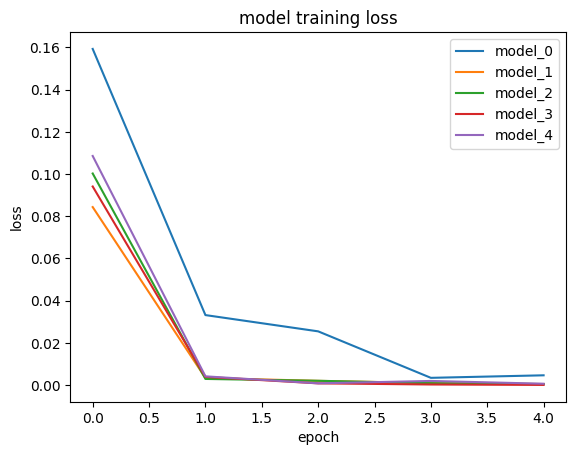

In [26]:
plt.title('model training loss')
plt.ylabel('loss')
plt.xlabel('epoch')
for key in history.keys():
    plt.plot(history[key].history['loss'], label="model_{}".format(key))
plt.legend()

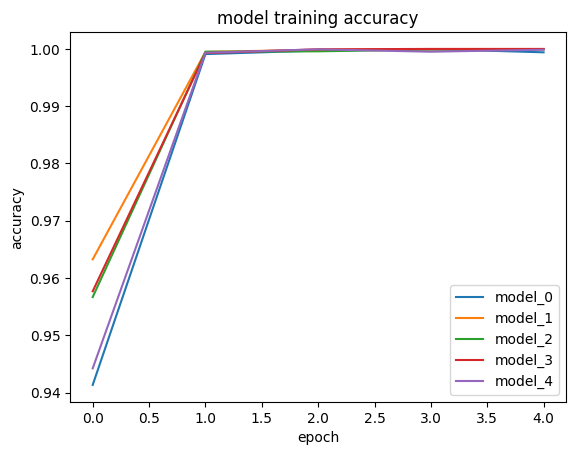

In [27]:
plt.title('model training accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
for key in history.keys():
    plt.plot(history[key].history['accuracy'], label="model_{}".format(key))
plt.legend()

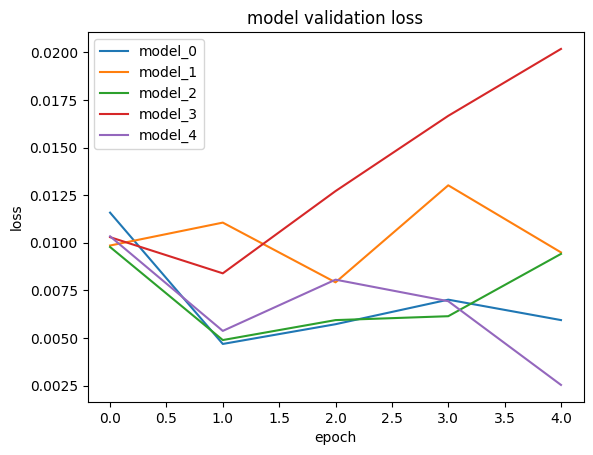

In [28]:
plt.title('model validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
for key in history.keys():
    plt.plot(history[key].history['val_loss'], label="model_{}".format(key))
plt.legend()

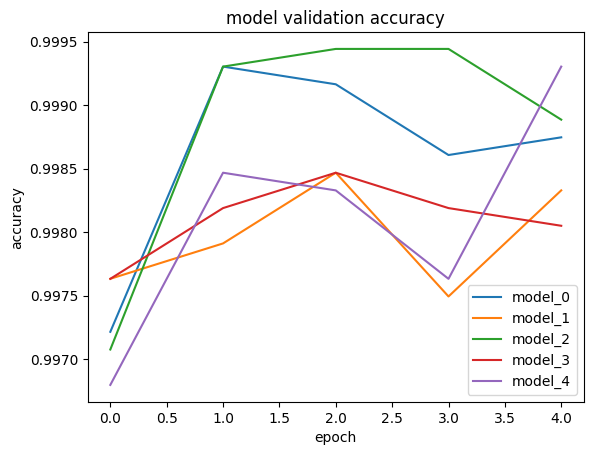

In [29]:
plt.title('model validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
for key in history.keys():
    plt.plot(history[key].history['val_accuracy'], label="model_{}".format(key))
plt.legend()

In [30]:
print("Loss: {}, Accuracy: {}, Precision: {}, Recall: {}, F1 Score: {}".format(
    np.average(loss), np.average(accuracy), np.average(precision), np.average(recall), np.average(F1)
))

Loss: 0.009740637708455324, Accuracy: 0.9982850790023804, Precision: 0.9970736742019654, Recall: 0.9993476152420044, F1 Score: 0.9982085547356702


In [31]:
best_model.save("Transformer_ISOT")

INFO:tensorflow:Assets written to: Transformer_ISOT\assets


INFO:tensorflow:Assets written to: Transformer_ISOT\assets


### Generalization

In [32]:
fakes_column_names = ["lemmatized_clean_final_article", "labels"]
fakes_data = pd.read_csv("../Preprocessed_Dataset/Fakes_Preprocessed_Data.csv", encoding='utf-8', encoding_errors='ignore')[fakes_column_names]
fnc_column_names = ["lemmatized_clean_final_article", "labels"]
fnc_data = pd.read_csv("../Preprocessed_Dataset/fnc-1_Preprocessed_Data.csv", encoding='utf-8', encoding_errors='ignore')[fnc_column_names]

In [33]:
fakes_x = token.texts_to_sequences(fakes_data[fakes_column_names[0]])
fakes_x = keras.preprocessing.sequence.pad_sequences(fakes_x, maxlen=SEQUENCE_LENGTH, padding='post', truncating="post")
fakes_y = fakes_data[fakes_column_names[1]]

fakes_loss, fakes_accuracy, fakes_precision, fakes_recall = best_model.evaluate(x=fakes_x, y=fakes_y)
fakes_F1 = 2 * (fakes_precision * fakes_recall) / (fakes_precision + fakes_recall)
print("FAKES Loss: {}, FAKES Accuracy: {}, FAKES Precision: {}, FAKES Recall: {}, FAKES F1: {}".format(fakes_loss, fakes_accuracy, fakes_precision, fakes_recall, fakes_F1))

26/26 [==============================] - 0s 14ms/step - loss: 4.9650 - accuracy: 0.4801 - precision_5: 0.5208 - recall_5: 0.2347
FAKES Loss: 4.964953422546387, FAKES Accuracy: 0.48009949922561646, FAKES Precision: 0.5208333134651184, FAKES Recall: 0.23474177718162537, FAKES F1: 0.32362458511845693


In [34]:
fnc_x = token.texts_to_sequences(fnc_data[fnc_column_names[0]])
fnc_x = keras.preprocessing.sequence.pad_sequences(fnc_x, maxlen=SEQUENCE_LENGTH, padding='post', truncating="post")
fnc_y = fnc_data[fnc_column_names[1]]

fnc_loss, fnc_accuracy, fnc_precision, fnc_recall = best_model.evaluate(x=fnc_x, y=fnc_y)
fnc_F1 = 2 * (fnc_precision * fnc_recall) / (fnc_precision + fnc_recall)
print("FNC Loss: {}, FNC Accuracy: {}, FNC Precision: {}, FNC Recall: {}, FNC F1: {}".format(fnc_loss, fnc_accuracy, fnc_precision, fnc_recall, fnc_F1))

142/142 [==============================] - 1s 7ms/step - loss: 8.8004 - accuracy: 0.2486 - precision_5: 0.8069 - recall_5: 0.1011
FNC Loss: 8.800430297851562, FNC Accuracy: 0.2485613077878952, FNC Precision: 0.8069414496421814, FNC Recall: 0.10114192217588425, FNC F1: 0.17975355971292117
